2024-03-22 08:53:32.578540: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 08:53:32.581794: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 08:53:32.621112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 08:53:33.559349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


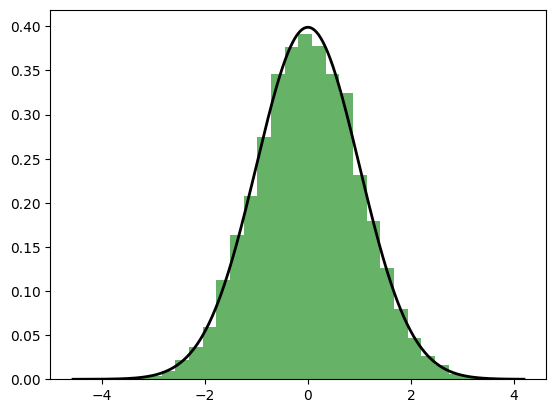

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm
import tensorflow as tf

# Define the number of samples, the location, the scale, and the skewness
num_samples = 10000
mu_data = 0.0  # location (mean) 
sd_data = 1.0  # scale (standard deviation) 
alpha_data = 0.0  # skewness (negative value means left skew, positive means right skew)

# Generate samples from the skew normal distribution
dist = skewnorm(alpha_data, mu_data, sd_data)
samples = dist.rvs(num_samples)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
# xmin = xmin + 1/7 * (xmax - xmin)
x = np.linspace(xmin, xmax, 1000)
p = skewnorm.pdf(x, alpha_data, mu_data, sd_data)
plt.plot(x, p, 'k', linewidth=2)
x_values = x 
y_values = p
plt.show()

In [2]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer='he_normal')
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [3]:
def skew_norm_pdf(x, location, scale, shape):
    # Standardize the input
    t = (x - location) / scale

    # PDF of the standard normal distribution
    pdf = tf.exp(-t**2 / 2) / np.sqrt(2*np.pi)

    # CDF of the standard normal distribution
    cdf = 0.5 * (1 + tf.math.erf(shape * t / np.sqrt(2)))

    return 2 * pdf * cdf


class OutputNeuron(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        x, mu, sd, alpha = inputs
        # x = tf.expand_dims(x, axis=-1)
        return skew_norm_pdf(x, mu, sd, alpha)

In [4]:
class SNRegressor(tf.keras.Model):
    def __init__(self, x, **kwargs):
        super().__init__(**kwargs)
        self.denseBlock1 = MyDense(64, activation='relu')
        self.denseBlock2 = MyDense(64, activation='relu')
        self.mu = MyDense(1)
        self.sd = MyDense(1, activation='softplus')
        self.alpha = MyDense(1)
        self.outputNeuron = OutputNeuron()
        self.x = x
        # self.out = tf.keras.layers.Dense(output_dim)

    def call(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z) + tf.keras.backend.epsilon()
        # print(sd)
        alpha = self.alpha(Z)
        return self.outputNeuron([self.x, mu, sd, alpha])
    
    def get_params(self, input):
        Z = self.denseBlock1(input)
        Z = self.denseBlock2(Z)
        mu = self.mu(Z)
        sd = self.sd(Z)
        alpha = self.alpha(Z)
        return mu, sd, alpha

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_values_reshaped = x_values.reshape(-1,1)
y_values_reshaped = y_values.reshape(-1,1)
X_train_scaled = scaler.fit_transform(x_values_reshaped)

In [6]:
tf.keras.utils.set_random_seed(42)
model = SNRegressor(x_values)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled, y_values_reshaped, epochs=10, batch_size=32)
# model.summary()

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0262
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0223 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0172 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0104 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0042 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0020 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0014 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0011 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 9.5918e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 8.3777e-04


In [7]:
mu, sd, alpha = model.get_params(x_values_reshaped)

In [8]:
print('mu:', tf.reduce_mean(mu))
print('sd:', tf.reduce_mean(sd))
print('alpha:', tf.reduce_mean(alpha))

mu: tf.Tensor(-46.100662, shape=(), dtype=float32)
sd: tf.Tensor(49.060562, shape=(), dtype=float32)
alpha: tf.Tensor(-5.8670864, shape=(), dtype=float32)


In [9]:
predictions = skewnorm.pdf(x_values, np.mean(alpha), np.mean(mu), np.mean(sd))

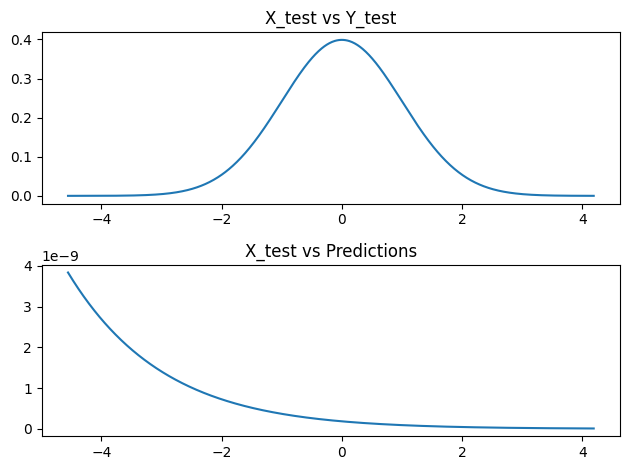

In [10]:
plt.figure()
# Create the first subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(x_values, y_values)
plt.title('X_test vs Y_test')

# Create the second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(x_values, predictions)
plt.title('X_test vs Predictions')

# Display the plots
plt.tight_layout()
plt.show()